# Questions for this project

### The goal of the project: Find 5 best zipcodes for investment:

* **What is the definition of best?**
* **What methods do I use to find best zipcodes?**
* **What method should I use to predict prices?**
* **How do I verify my results?**

# Step 1: Load the Data

In [2]:
#import all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.style.use('seaborn')

In [3]:
df = pd.read_csv('zillow_data.csv')
print(df.shape)
df.head()

(14723, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

First I am going to drop columns which I won't need in my filtering process.

In [4]:
zipcodes = df.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
zipcodes.dropna(inplace=True)
df.dropna(inplace=True)
zipcodes.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


I am going to find houses with the fastest growth rate. Also I will compare first and last price for each zipcode and find the ones that gained the most value.

In [5]:
# create df to store and compare my findings
df_gr = pd.DataFrame(df, columns=['RegionName', 'City', 'State'])
cols = zipcodes.drop(['RegionName'], axis=1)
df_gr['growth_rate'] = 0

# find and store the percentage change for each month
for num in range(len(cols.columns)-1):
    df_gr['growth_rate'] += (1 - cols.iloc[:,num] / cols.iloc[:,num+1]) * 100

# divide by the total number of months and find the mean change in %   
df_gr['growth_rate'] = df_gr['growth_rate'] / (len(cols.columns)-1)

# find difference between first and last price in %
df_gr['first_vs_last'] = (1 - zipcodes['1996-04'] / zipcodes['2018-04']) * 100

df_gr['current_price'] = zipcodes['2018-04']

In [6]:
df_gr.sort_values('growth_rate', ascending=False).head(10)

,RegionName,City,State,growth_rate,first_vs_last,current_price
117,11211,New York,NY,0.934720,91.796514,1623700
1155,11222,New York,NY,0.913009,91.331125,1721100
475,11216,New York,NY,0.894594,90.861325,1598700
191,7302,Jersey City,NJ,0.876249,90.387445,1427300
106,11215,New York,NY,0.859756,89.941620,2243900
13864,11975,Wainscott,NY,0.858857,89.921564,3467800
11728,11930,Amagansett,NY,0.846113,89.545064,3141100
14217,80449,Hartsel,CO,0.819996,88.793425,267700
1790,90291,Los Angeles,CA,0.813653,88.608518,2056800
258,20001,Washington,DC,0.808496,88.402874,793300


Looks like New York is our best bet. All prices here seem to be growing at good and steady pace. Let's also check first vs last price and the most expensive houses.

In [7]:
df_gr.sort_values('first_vs_last', ascending=False).head(10)

,RegionName,City,State,growth_rate,first_vs_last,current_price
117,11211,New York,NY,0.934720,91.796514,1623700
1155,11222,New York,NY,0.913009,91.331125,1721100
475,11216,New York,NY,0.894594,90.861325,1598700
191,7302,Jersey City,NJ,0.876249,90.387445,1427300
106,11215,New York,NY,0.859756,89.941620,2243900
13864,11975,Wainscott,NY,0.858857,89.921564,3467800
11728,11930,Amagansett,NY,0.846113,89.545064,3141100
14217,80449,Hartsel,CO,0.819996,88.793425,267700
1790,90291,Los Angeles,CA,0.813653,88.608518,2056800
258,20001,Washington,DC,0.808496,88.402874,793300


No change here. 

In [8]:
df_gr.sort_values('current_price', ascending=False).head(10)

,RegionName,City,State,growth_rate,first_vs_last,current_price
21,10128,New York,NY,0.248839,50.224731,7386600
10237,94027,Atherton,CA,0.656935,82.649893,6796500
4816,90210,Beverly Hills,CA,0.664597,82.953649,5956700
5738,94301,Palo Alto,CA,0.717853,85.275195,4818400
7596,81611,Aspen,CO,0.445954,69.724751,4766600
4723,33480,Palm Beach,FL,0.596158,79.548461,4686200
2026,94123,San Francisco,CA,0.641137,81.865750,4682300
5843,94022,Los Altos,CA,0.638435,81.804876,4372600
7380,90402,Santa Monica,CA,0.585407,78.942331,4179000
742,94115,San Francisco,CA,0.621757,80.915755,4160500


Looks like California has most expensive houses which also grow at a good pace.

In [9]:
df_gr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12895 entries, 0 to 14722
Data columns (total 6 columns):
RegionName       12895 non-null int64
City             12895 non-null object
State            12895 non-null object
growth_rate      12895 non-null float64
first_vs_last    12895 non-null float64
current_price    12895 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.3+ MB


Most expensive doesn't mean most profitable. These houses were always expensive and prices grow much slower.

Let's take a look and the distribution of our growth rate.

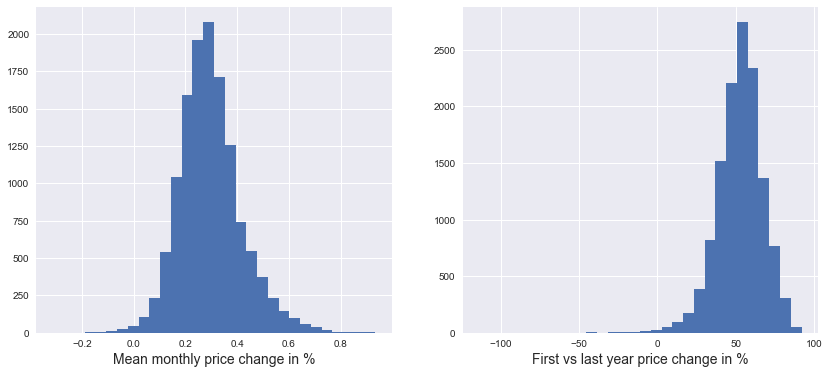

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.hist(df_gr['growth_rate'], bins=30)
plt.xlabel('Mean monthly price change in %', fontsize=14)
plt.subplot(122)
plt.hist(df_gr['first_vs_last'], bins=30)
plt.xlabel('First vs last year price change in %', fontsize=14)

plt.show();

Overall most houses are getting more expensive but very few grow at such a good pace as 0.8% per month. So I am going to keep 10 to 15 houses with fastest growing prices. Then I will do further analisys and pick 5 most perspectve ones.

In [11]:
df['growth_rate'] = df_gr['growth_rate']
df['first_vs_last'] = df_gr['first_vs_last']

df = df[df['2018-04'] >= 1000000]
df = df[(df['growth_rate'] >= 0.75) & (df['first_vs_last'] >= 85)]

print(df.shape)

(13, 274)


Here are the nominants for top five:

In [12]:
df.drop(['RegionID', 'Metro', 'CountyName', 'SizeRank', 'growth_rate', 'first_vs_last'], axis=1, inplace=True)
df

,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
70,11221,New York,NY,133700.0,133700.0,133700.0,133700.0,133900.0,134000.0,134300.0,...,944500,948200,965300,984700,995000,998100,1000900,1015400,1037300,1048700
76,94110,San Francisco,CA,213900.0,214800.0,216000.0,217500.0,219200.0,221200.0,223700.0,...,1503000,1506400,1513500,1525200,1533600,1536500,1536200,1544400,1570000,1594000
106,11215,New York,NY,225700.0,227500.0,229400.0,231600.0,234100.0,236900.0,239800.0,...,2173600,2201100,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900
117,11211,New York,NY,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700
191,7302,Jersey City,NJ,137200.0,137800.0,138500.0,139100.0,139600.0,140100.0,140700.0,...,1340200,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300
475,11216,New York,NY,146100.0,146600.0,147200.0,147700.0,148400.0,149300.0,150200.0,...,1452000,1506100,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700
1155,11222,New York,NY,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,...,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100
1790,90291,Los Angeles,CA,234300.0,234200.0,234200.0,234200.0,234100.0,234200.0,234600.0,...,1994700,2017200,2043700,2056400,2046300,2028900,2039400,2058500,2064200,2056800
3339,94306,Palo Alto,CA,440600.0,441700.0,443100.0,444800.0,446900.0,449300.0,452200.0,...,2801100,2826500,2872300,2937300,3011100,3076900,3129800,3183700,3245800,3285100
11172,11976,Water Mill,NY,400000.0,402700.0,405700.0,408900.0,412600.0,416700.0,421400.0,...,3076900,3108200,3120400,3130900,3145100,3158200,3176000,3207400,3233700,3241400


In [13]:
# check for null values
df.isna().sum().sum()

0

# Step 3: ARIMA Modeling

For this project I am going to use ARIMA model to predict house prices for the next year. Houses with highest predicted growth rate will make it to the top 5.

### 3.1 Functions

First of all I will make some functions that will help me with my modeling.

In [14]:
def get_datetimes(df):
    
    '''transforms dates to datetime format'''
    
    return pd.to_datetime(df.columns.values[3:], format='%Y-%m')

def melt_data(df):
    
    '''transforms data to long format'''
    
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [15]:
def find_pdq(ts, param_pool=5):
    
    '''returns p,d,q parameters with highest aic for ARIMA model'''
   
    p=d=q=range(0,param_pool)
    pdq = list(itertools.product(p,d,q))
    aics = []
    for param in pdq:
        try:
            model_arima = ARIMA(ts,order=param)
            model_arima_fit = model_arima.fit()
            aics.append([param, model_arima_fit.aic])
        except:
            continue
    aics_df = pd.DataFrame(aics, columns=['pdq', 'aic'])
    pdq = aics_df.loc[aics_df['aic'].idxmin()]
    return pdq[0]

In [16]:
def test_predictions(ts, test_size=0.05):
    
    ''' predicts values for given test size using ARIMA model
        returns plot with actual and predicted values '''
    
    size = int(len(ts) * (1 - test_size))  # find the index number that will split the data
    train, test = ts[0:size], ts[size:len(ts)] # split data into train/test
    predictions = train.copy() 
    
    for t in range(len(test)): # forcast 1 step ahead, update ts with predicted data, then repeat on updated ts  
        pdq = find_pdq(predictions)  # get best parameters for each step of forecast
        model = ARIMA(predictions, order=pdq, enforce_stationarity=False, 
                      enforce_invertibility=False)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.loc[predictions.index.max()+pd.DateOffset(months=1)] = yhat # add a next index date and prediction 
        
    #print(predictions[size:len(ts)], test)
    print('RMSE: ', np.sqrt(mean_squared_error(predictions[size:len(ts)], test))) # evaluate the quality of prediction
    plt.figure(figsize=(14,7))
    plt.plot(test, label='actual')
    plt.plot(predictions[size:len(ts)], label = 'predictions', color='red')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper left', fontsize=16)
    plt.show()

In [17]:
def forecast(ts, periods=1):
    
    '''Predicts values for given number of periods using ARIMA model.
       Returns: list of predicted values, time series with predicted values, 
             rate of change between last actual value and last predicted value '''
        
    predictions = []
    time_s = ts.copy()
    
    for t in range(periods):
        pdq = find_pdq(time_s)
        model = ARIMA(time_s, order=pdq, enforce_stationarity=False, 
                      enforce_invertibility=False)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        time_s.loc[time_s.index.max()+pd.DateOffset(months=1)] = yhat
    
    growth_rate = (1 - (ts.value[-1] / predictions[-1])) * 100
    return predictions, time_s['2018-04-01':], growth_rate 
    

In [18]:
def plot_forecast(ts, periods=1):
    
    '''Predicts values for given number of periods using ARIMA model.
       Returns: plot with actual and predicted values marked with different colors,
                rate of change between last actual value and last predicted value'''
    
    forecast_ = forecast(ts, periods=periods)
    
    print('Predicted growth rate in ', periods, 'month period = ', np.round(forecast_[2], 1), '%')
    
    plt.figure(figsize=(14,7))
    plt.plot(ts['2008-04-01':], label='prices') # plots actual data starting at year 2008 for better view
    plt.plot(forecast_[1], label='predictions', color='red') #plots predicted data in red color
    plt.axvline('2018-04-01', color='black') # show where forecast starts
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper left', fontsize=14)
    plt.show()
    
    return forecast_[2] # returns growth rate

## 3.2 Testing

In [19]:
# transform all dates to datetime format
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

On a plot below we can see how prices were changing over the years for our candidates. We can see that they all recovered pretty well after 2008 crisis

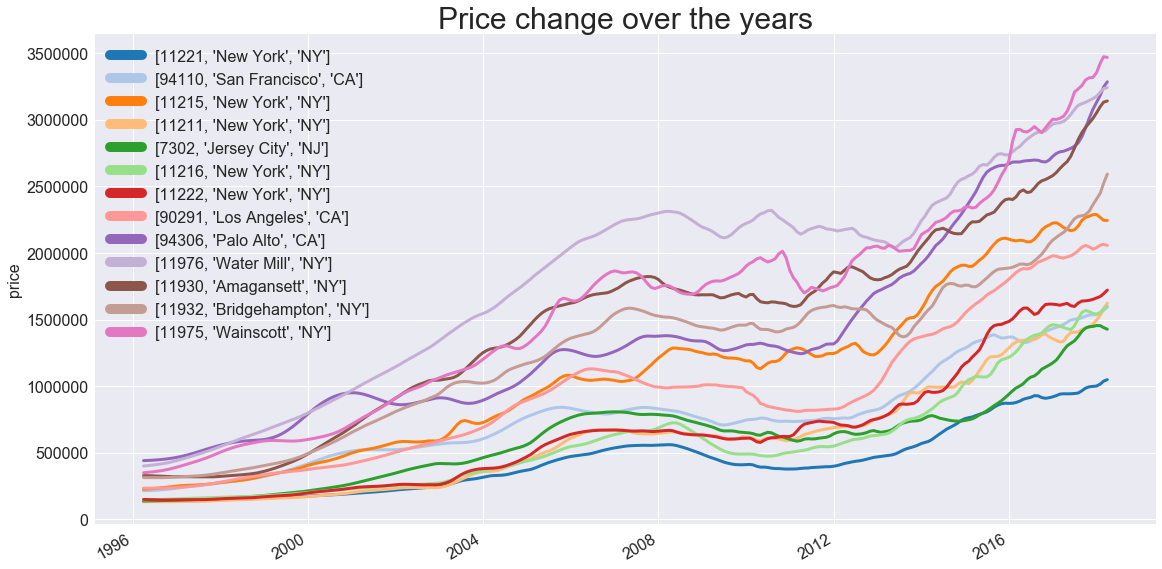

In [20]:
zips = df.RegionName.values
plt.figure(figsize=(19,10))
palette = plt.get_cmap('tab20')

for ind, zipcode in enumerate(zips):
    df_melt = melt_data(df[df['RegionName'] == zipcode])
    city = df.loc[df['RegionName'] == zipcode, 'City'].values[0]
    state = df.loc[df['RegionName'] == zipcode, 'State'].values[0]
    plt.plot(df_melt, label=[zipcode, city, state], color=palette(ind), linewidth=3)   

plt.title('Price change over the years', fontsize=30)
plt.ylabel('price', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
leg = plt.legend(loc='upper left', fontsize=16)

for legobj in leg.legendHandles:
    legobj.set_linewidth(10.0)

plt.gcf().autofmt_xdate()
plt.show()
    
    

Before making actual predictions I tested this method using my test_prediction function. On the plots below we can see that predictions are pretty accurate. So I am going to proceed.

New York NY 11221
RMSE:  20154.476126708858


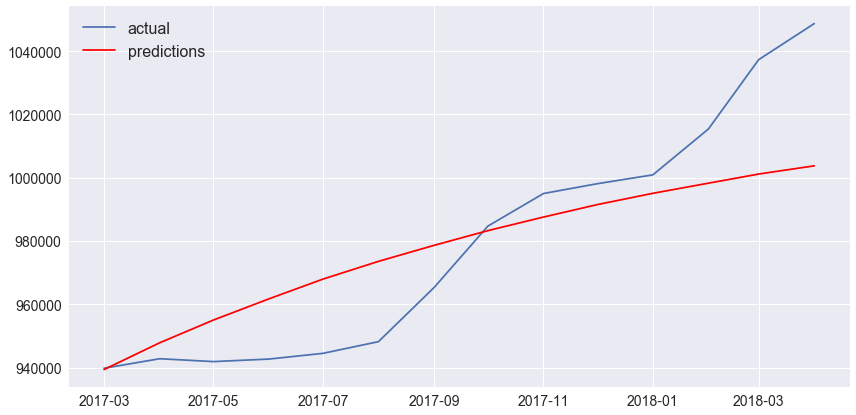

San Francisco CA 94110
RMSE:  43640.253631730186


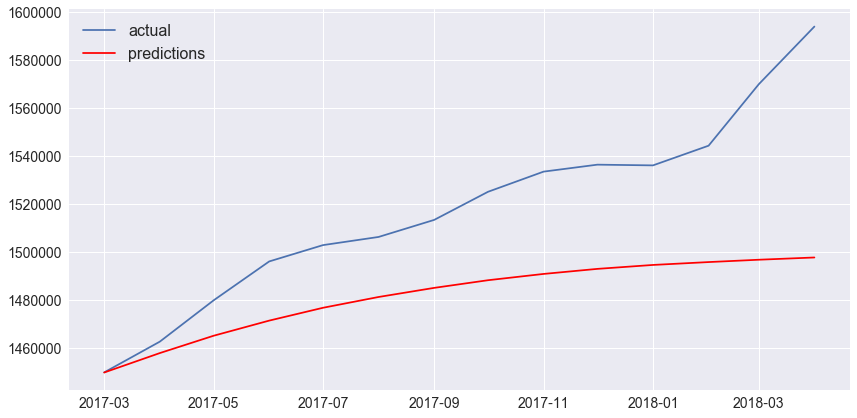

New York NY 11215
RMSE:  51065.52312584828


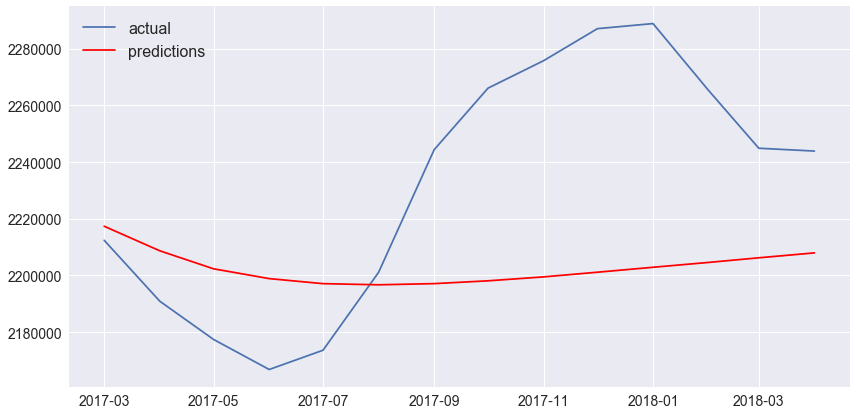

New York NY 11211
RMSE:  186560.4558090059


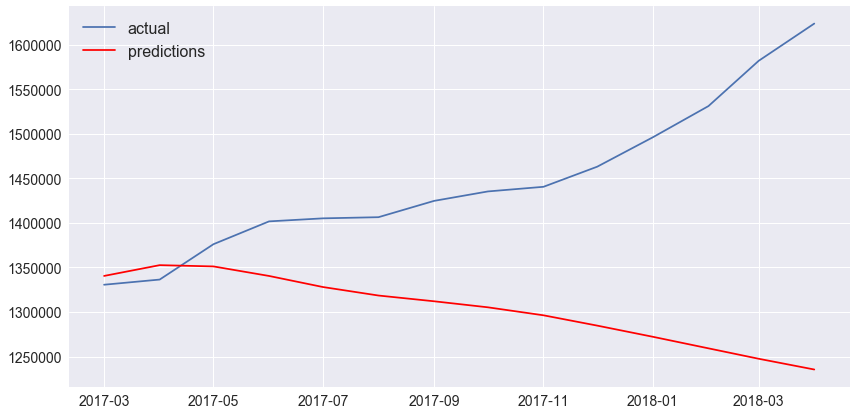

Jersey City NJ 7302
RMSE:  59487.4548113852


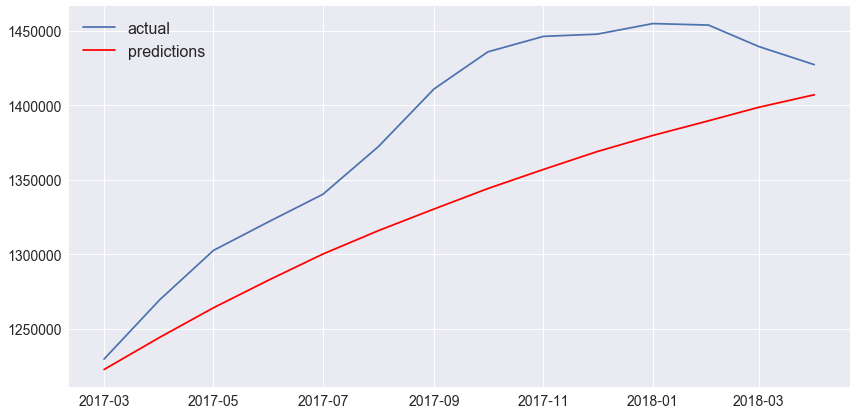

New York NY 11216
RMSE:  163836.9064816778


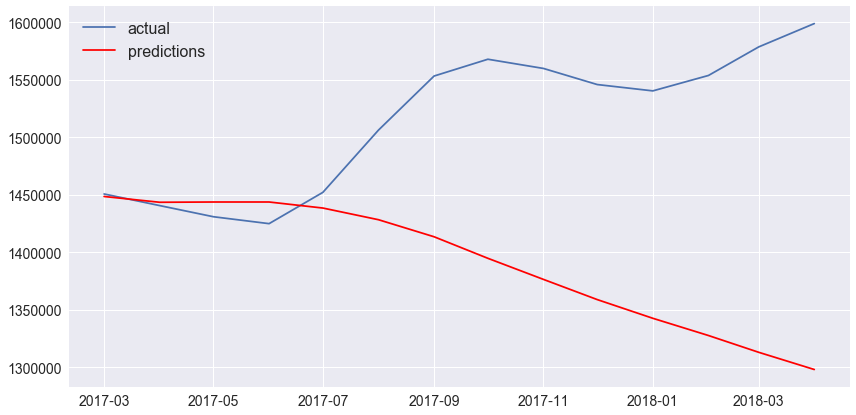

New York NY 11222
RMSE:  23440.281540454296


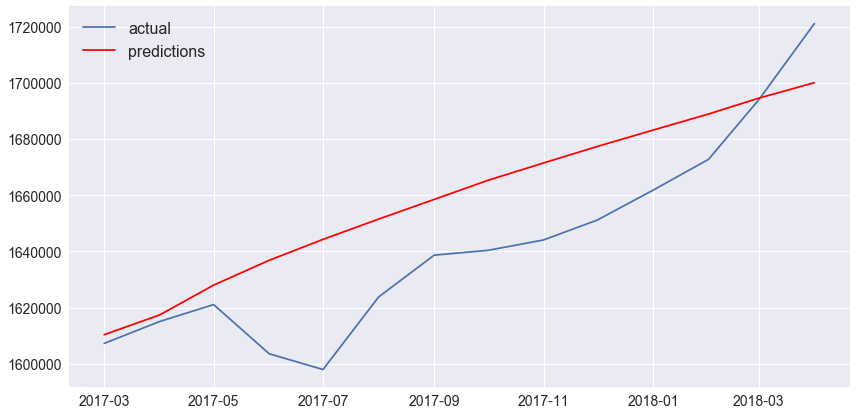

Los Angeles CA 90291
RMSE:  320794.83965528134


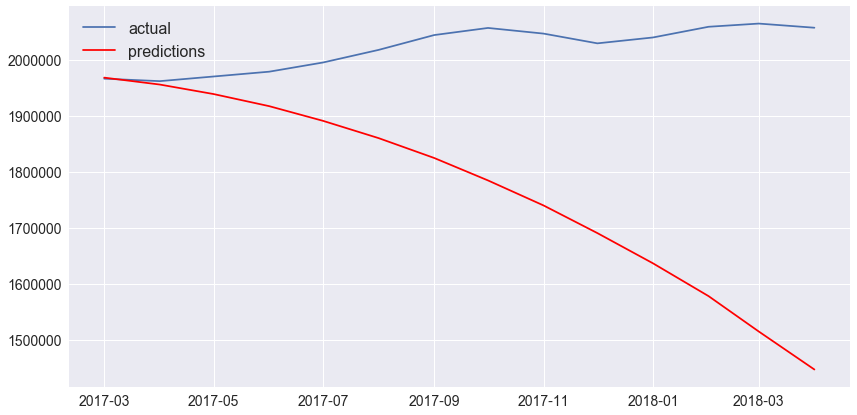

Palo Alto CA 94306
RMSE:  198466.17331163227


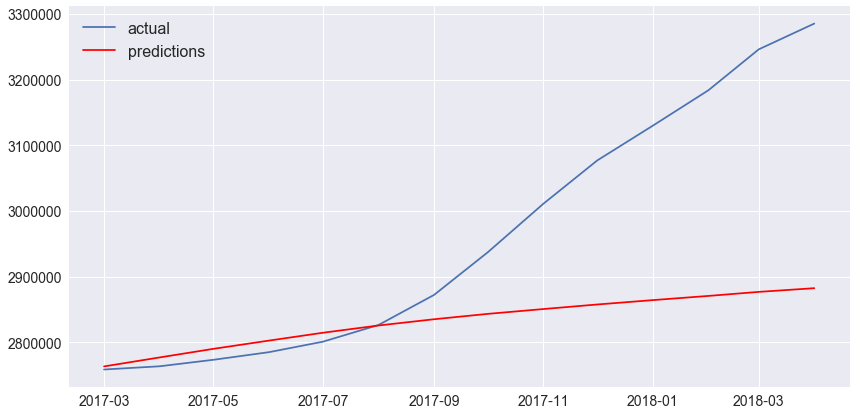

Water Mill NY 11976
RMSE:  169082.72733650083


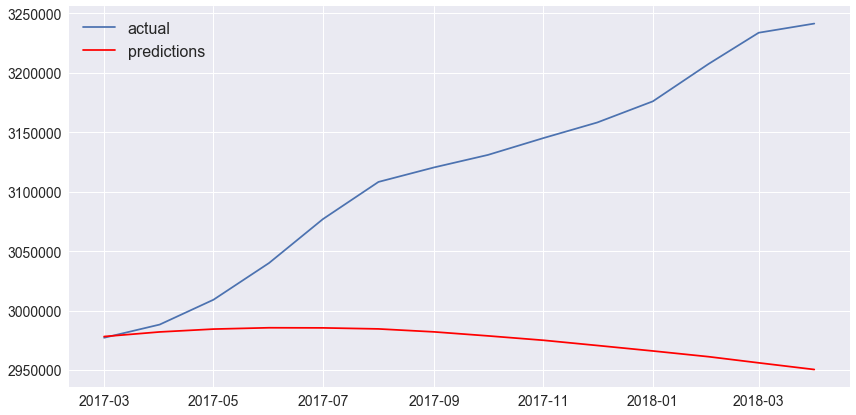

Amagansett NY 11930
RMSE:  274054.4770167289


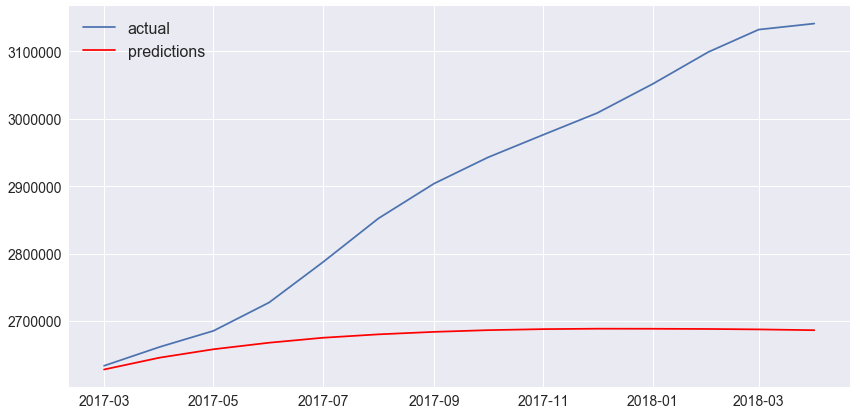

Bridgehampton NY 11932
RMSE:  154186.10441899166


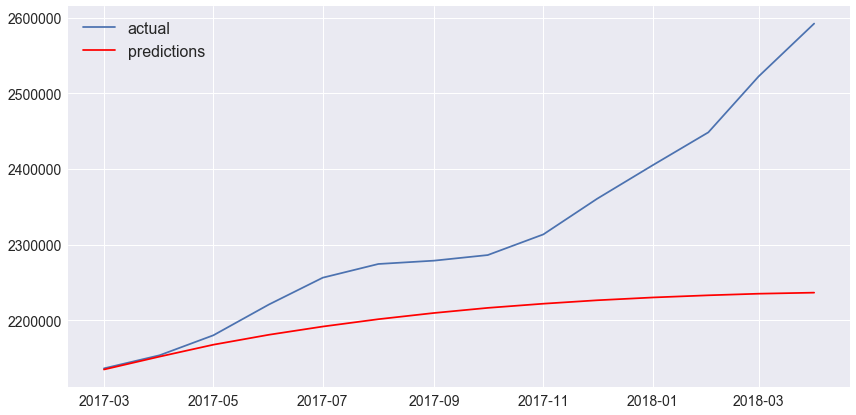

Wainscott NY 11975
RMSE:  368628.1879959914


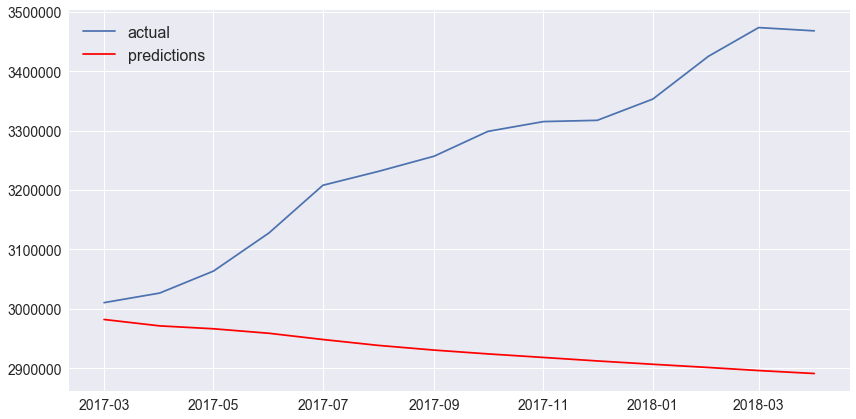

In [21]:
for zipcode in zips:
    df_melt = melt_data(df[df['RegionName'] == zipcode])
    df_melt = df_melt
    city = df.loc[df['RegionName'] == zipcode, 'City'].values[0]
    state = df.loc[df['RegionName'] == zipcode, 'State'].values[0]
    print(city, state, zipcode)
    test_predictions(df_melt, 0.05)

Some of the predictions are pretty good, some not so much. Overall I find it to work well from the risks point of view because none of the predictions showed that price will go up when it actually didn't.

## 3.3 Predictions

Now to the actual predictions:

New York NY 11221
Predicted growth rate in  12 month period =  2.5 %


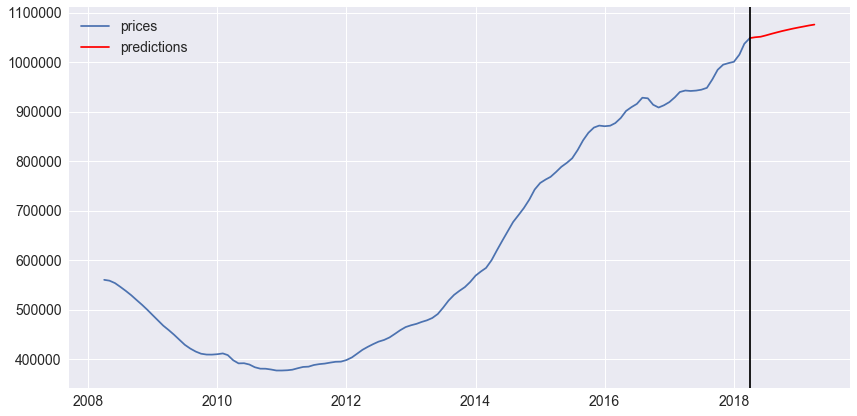

San Francisco CA 94110
Predicted growth rate in  12 month period =  6.2 %


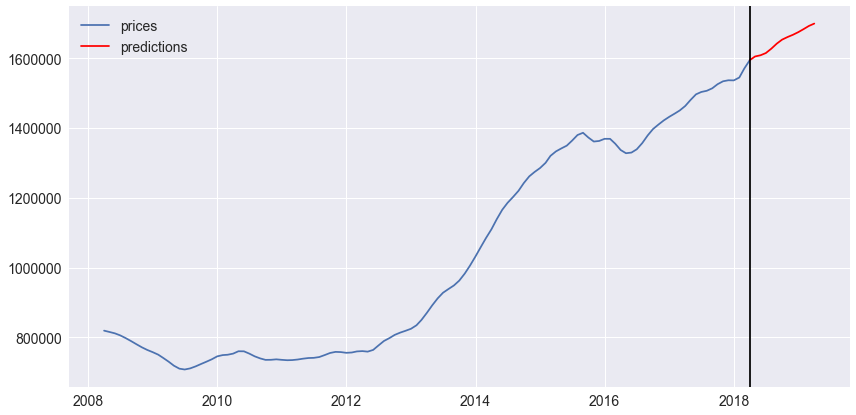

New York NY 11215
Predicted growth rate in  12 month period =  1.2 %


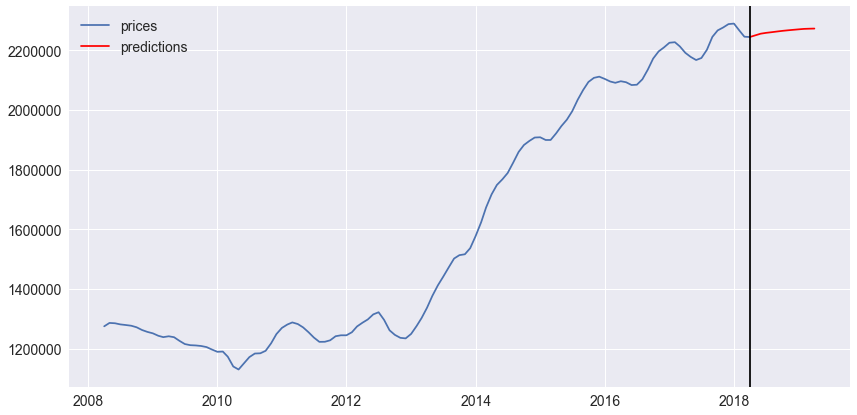

New York NY 11211
Predicted growth rate in  12 month period =  50.5 %


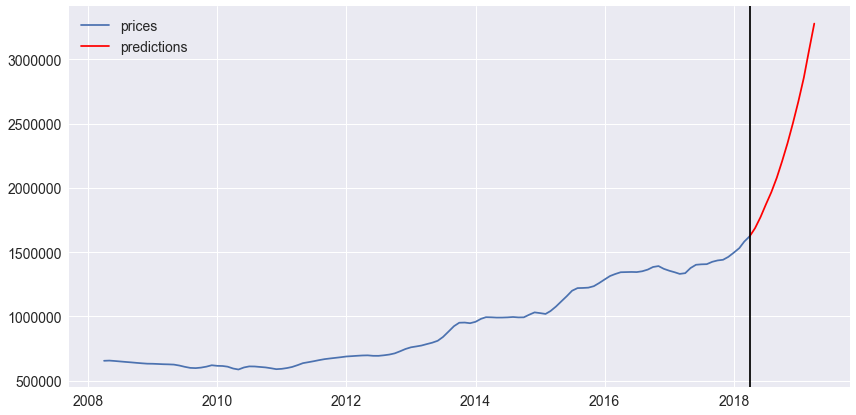

Jersey City NJ 7302
Predicted growth rate in  12 month period =  -3.5 %


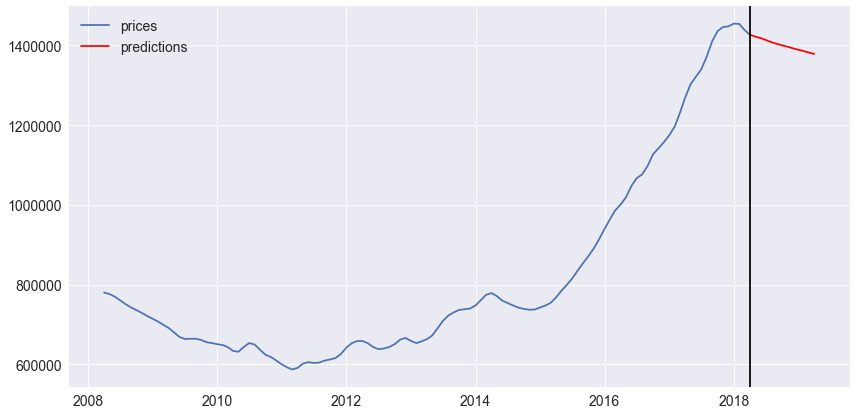

New York NY 11216
Predicted growth rate in  12 month period =  7.4 %


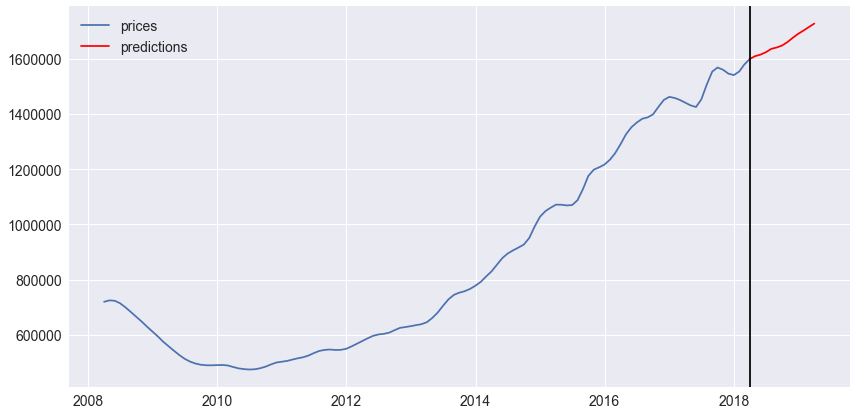

New York NY 11222
Predicted growth rate in  12 month period =  6.4 %


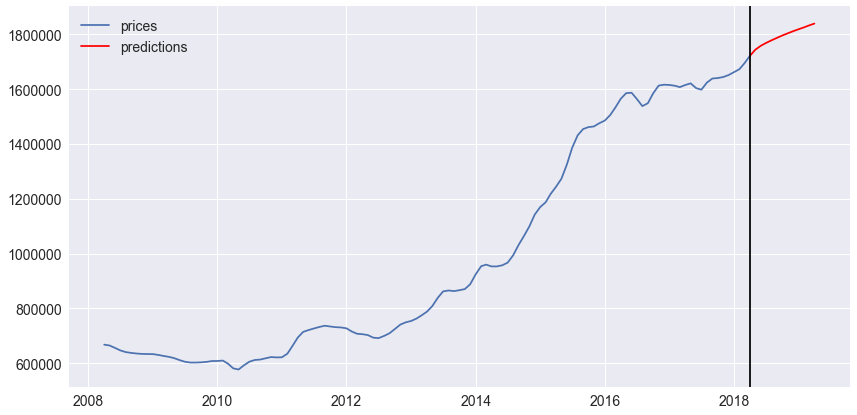

Los Angeles CA 90291
Predicted growth rate in  12 month period =  -1.4 %


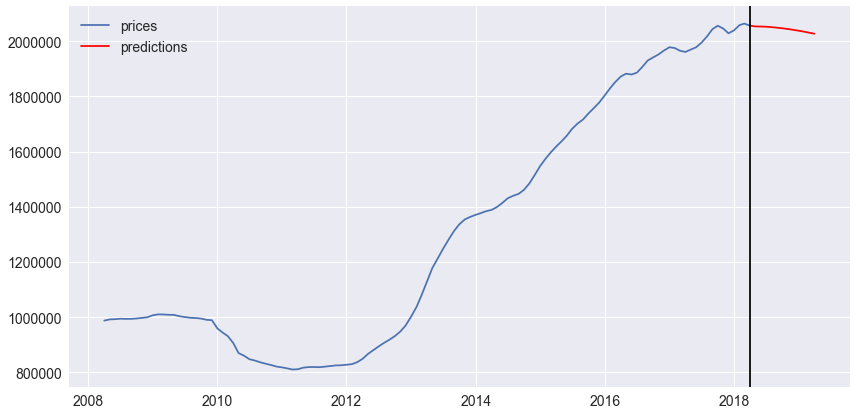

Palo Alto CA 94306
Predicted growth rate in  12 month period =  7.8 %


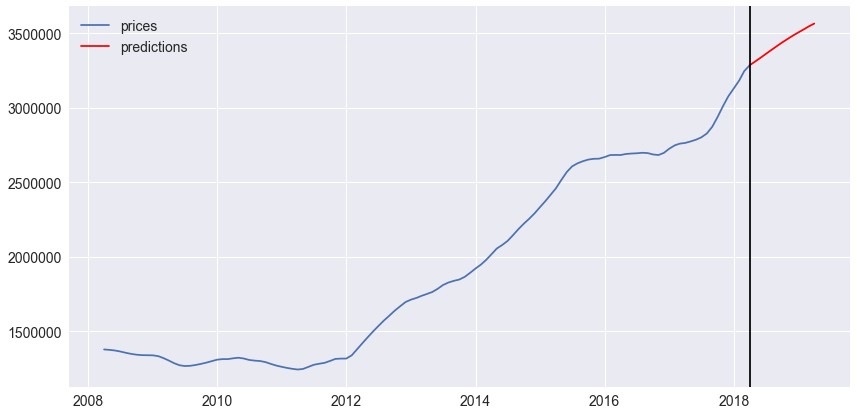

Water Mill NY 11976
Predicted growth rate in  12 month period =  0.1 %


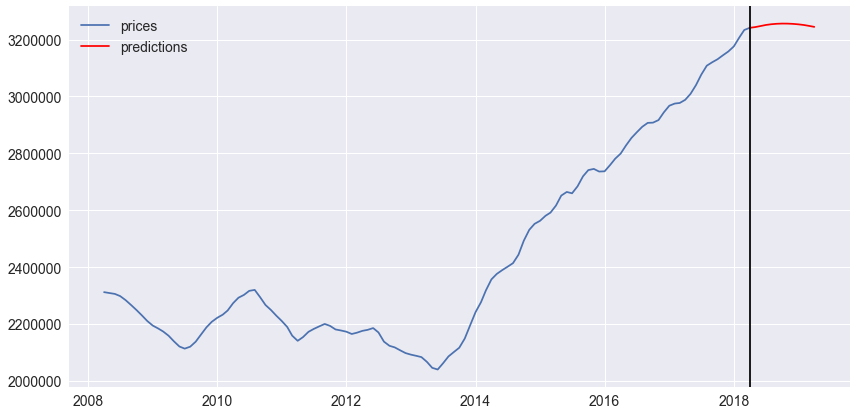

Amagansett NY 11930
Predicted growth rate in  12 month period =  2.0 %


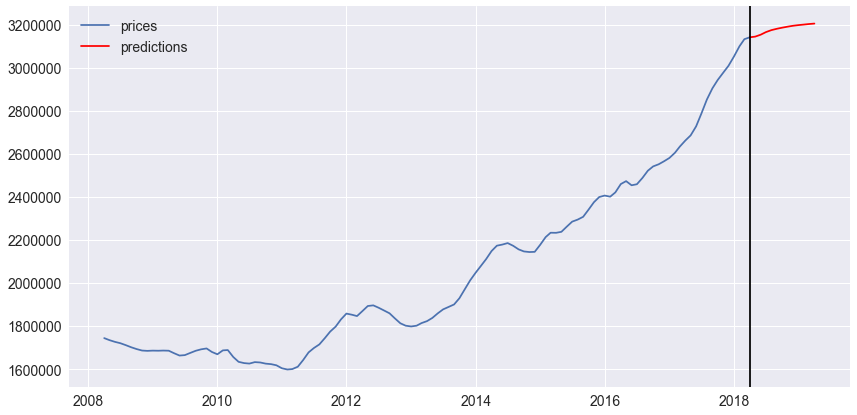

Bridgehampton NY 11932
Predicted growth rate in  12 month period =  15.8 %


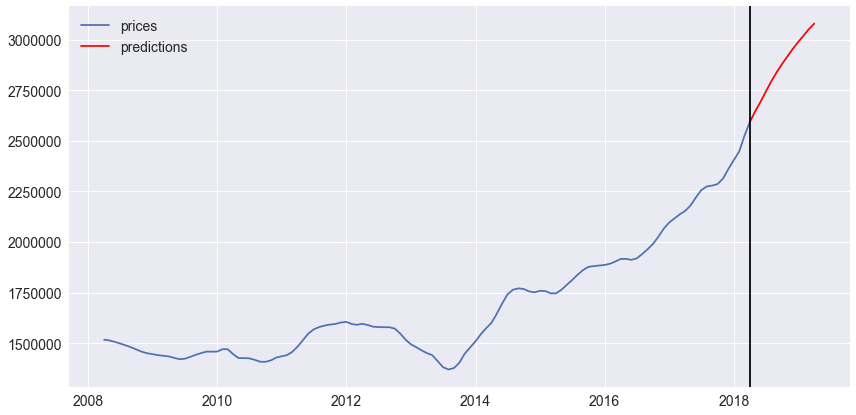

Wainscott NY 11975
Predicted growth rate in  12 month period =  3.0 %


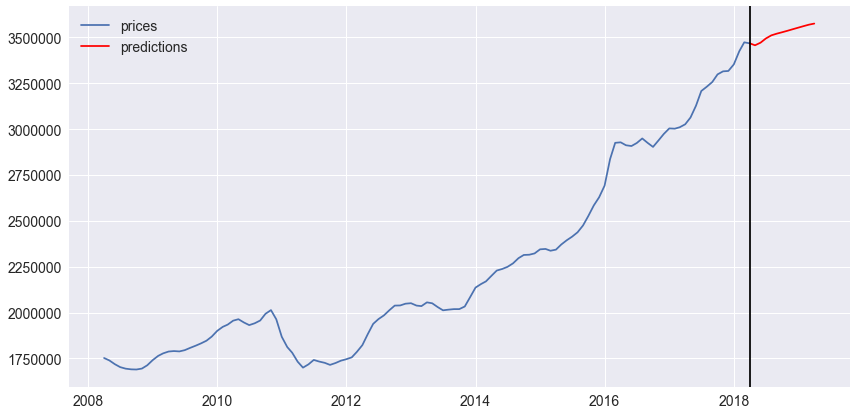

In [22]:
predicted_growth = []

for zipcode in zips:
    df_melt = melt_data(df[df['RegionName'] == zipcode])
    df_melt = df_melt
    city = df.loc[df['RegionName'] == zipcode, 'City'].values[0]
    state = df.loc[df['RegionName'] == zipcode, 'State'].values[0]
    print(city, state, zipcode)
    result = plot_forecast(df_melt, periods=12) # plots forecast and calculates its growth rate
    predicted_growth.append([city, state, zipcode, result])

In [23]:
predicted_growth_df = pd.DataFrame(predicted_growth, columns=['City', 'State', 'Zipcode', 'Predicted_growth_%'])
predicted_growth_df['Predicted_growth_%'] = np.round(predicted_growth_df['Predicted_growth_%'], 1)

best_zips = predicted_growth_df.Zipcode.values
pr_year = []
curr_prices = []

for zipcode in best_zips:
    curr = df[df['RegionName'] == zipcode]
    price_change = (1 - curr['2017-04'] / curr['2018-04']) * 100
    current_price = curr['2018-04']
    pr_year.append(int(price_change))
    curr_prices.append(int(current_price))

predicted_growth_df['Previous_year_growth_%'] = pr_year
predicted_growth_df['Current_median_price'] = curr_prices

    
predicted_growth_df = predicted_growth_df.sort_values('Predicted_growth_%', ascending=False)[:5]
predicted_growth_df

,City,State,Zipcode,Predicted_growth_%,Previous_year_growth_%,Current_median_price
3,New York,NY,11211,50.5,17,1623700
11,Bridgehampton,NY,11932,15.8,16,2592100
8,Palo Alto,CA,94306,7.8,15,3285100
5,New York,NY,11216,7.4,9,1598700
6,New York,NY,11222,6.4,6,1721100


Here are the winners. Zipcodes with over the average median price, highest growth rate over the years and highest predicted growth rate.

# Step 4: Interpreting Results

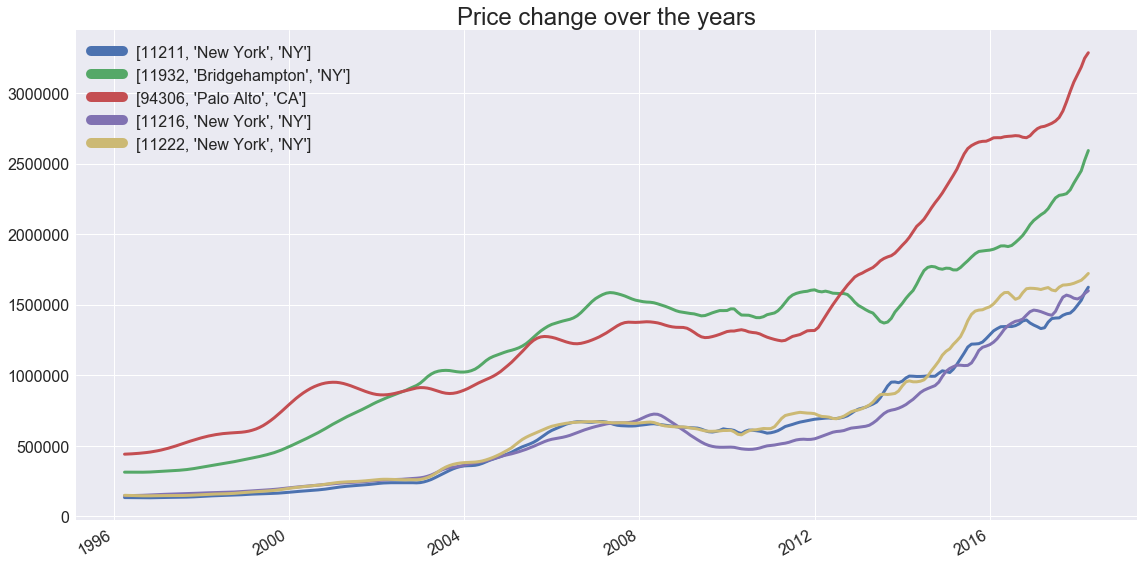

In [24]:
plt.figure(figsize=(19,10))

for zipcode in predicted_growth_df.Zipcode:
    df_melt = melt_data(df[df['RegionName'] == zipcode])
    city = df.loc[df['RegionName'] == zipcode, 'City'].values[0]
    state = df.loc[df['RegionName'] == zipcode, 'State'].values[0]
    plt.plot(df_melt, label=[zipcode, city, state], linewidth=3)   

plt.title('Price change over the years', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
leg = plt.legend(loc='upper left', fontsize=16)

for legobj in leg.legendHandles:
    legobj.set_linewidth(10.0)

    plt.gcf().autofmt_xdate()
plt.show()
    

The goal of the project was: Find 5 best zipcodes for investment:

### Problems:

1. What is the definition of best zipcode for investment?
2. What methods do I use to find best zipcodes?
3. What method should I use to predict prices?
4. How do I verify my results?

### Solution:

 **1.**   The best area for investment is the one that brings maximum profit with minimum risks. 

* First It has to have good history of prices with steady growth over the years. This will make it a safe candidate for a long term investment and lower risk of losing money in a long run. 
* Second It has to show a good upward trend in recent years and in near future predictions. 

A balance between these two factors makes a best area for investment.

**2.**  I filtered through all zipcodes and found the ones:
* with most average monthly growth. 
* that gained most value compared to the first year. 
* that fall into upper 50% of the all prices.

As a result I got 13 zipcodes 

**3.** For prediction I used ARIMA model from statsmodels library. In order to find best parameters for ARIMA model I used AIC estimator. I calculated predicted growth rate for all 13 zipcodes and picked 5 with highest score.

**4.** To test my predictions I used ARIMA model to predict the last year of time series, then compared the predicted and actual values. The results were satisfactory so I proceeded with the future year predictions.